In [39]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

Fetching reference HEAD


[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 23018.69it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [40]:
from ai2thor.controller import Controller

house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

In [41]:
import torch
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import clip
from collections import deque
from PIL import Image
import matplotlib.pyplot as plt


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

ACTIONS = ["MoveAhead", "MoveBack", "RotateRight", "RotateLeft"]
NUM_ACTIONS = len(ACTIONS)

IMG_SIZE = 300
GAMMA = 0.99
GAE_LAMBDA = 0.95
PPO_CLIP = 0.2
ENTROPY_COEF = 0.05
VALUE_COEF = 0.5
LR = 3e-4
TRAIN_EPOCHS = 150
MINIBATCHES = 4
ROLLOUT_STEPS = 1024
EPISODE_STEPS = ROLLOUT_STEPS // MINIBATCHES
MAX_GRAD_NORM = 0.5
EPSILON = 0.2
FEAT_DIM = 256
MAX_TRANSFORMER_SEQ_LEN = 128

transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),  # -> float in [0,1], shape (3,H,W)
        ])

# ------------------------ Model (shared encoder) ------------------------
class CNNEncoder(nn.Module):
    """Shape-safe: no hardcoded flatten size; uses GAP -> Linear(feat_dim)."""
    def __init__(self, feat_dim: int, n_hidden: int):
        super().__init__()
        self.feat_dim = feat_dim
        self.conv = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, 5, 2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # /4
        
            # Block 2
            nn.Conv2d(32, 64, 5, 1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # /8

            nn.Conv2d(64, 64, 5, 2, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # /16

            *self._block(n_hidden)
        )
        
        self.gap  = nn.AdaptiveAvgPool2d((1,1))
        self.proj = nn.Linear(64, feat_dim)

    def _block(self, n_hidden: int):
        return [
            layer
            for _ in range(n_hidden)
            for layer in (
                nn.Conv2d(64, 64, 3, 1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(2),
            )
        ]

    def forward(self, x):
        b, s, c, h, w = x.shape
        x = x.reshape(b*s, c, h, w)
        z = self.conv(x)                # (B*S,64,h,w)
        z = self.gap(z).squeeze(-1).squeeze(-1)  # (B*S,S,64)
        z = self.proj(z)                # (B*S,S,feat_dim)
        return z.view(b, s, self.feat_dim)

class Actor(nn.Module):
    def __init__(self, feat_dim, num_actions, n_layers=2, n_heads=8):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feat_dim, nhead=n_heads, dim_feedforward=4*feat_dim, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.policy_head = nn.Linear(feat_dim, num_actions)

    def forward(self, feats_seq):
        # feats_seq: (B, seq_len, feat_dim)
        z = self.transformer(feats_seq)  # (B, seq_len, feat_dim)
        pooled = z.mean(dim=1)           # temporal average pooling
        logits = self.policy_head(pooled)
        return logits


class Critic(nn.Module):
    def __init__(self, feat_dim):
        super().__init__()
        self.value_head = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(),
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(),
            nn.Linear(feat_dim, 1)
        )

    def forward(self, feat):  # feat: (B, feat_dim)
        return self.value_head(feat)


class RNDIntrinsicReward(nn.Module):
    """
    Random Network Distillation:
    Fixed (random) target; train predictor to match it.
    Intrinsic reward = prediction error (MSE), normalized online.
    """
    def __init__(self, feat_dim=FEAT_DIM, n_hidden=2, lr=1e-5, device=DEVICE, ema_beta=0.99, eps=1e-8):
        super().__init__()
        self.device = device
        self.feat_dim = feat_dim
        self.n_hidden = n_hidden
        self.rnd_mean = 0.0
        self.rnd_var  = 1.0
        self.ema_beta = ema_beta
        self.eps = eps

        # Fixed target (no grad)
        self.target = CNNEncoder(feat_dim, n_hidden).to(device)
        for p in self.target.parameters():
            p.requires_grad = False
        self.target.eval()

        # Trainable predictor
        self.predictor = CNNEncoder(feat_dim, n_hidden).to(device)
        self.predictor.train()

        self.optimizer = torch.optim.Adam(self.predictor.parameters(), lr=lr)
        self.mse = nn.MSELoss(reduction='none')
        self.lr = lr

    def compute_reward(self, obs_t: torch.Tensor) -> float:
        """
        obs_t: (3,H,W) or (1,3,H,W); CNNEncoder handles unsqueeze.
        Returns scalar normalized intrinsic reward.
        """
        with torch.no_grad():
            tgt = self.target(obs_t)              # (B, feat_dim)

        pred = self.predictor(obs_t)              # (B, feat_dim)
        
        err_vec = (pred - tgt).pow(2).mean(dim=-1)  # (1,)
        raw = err_vec.detach().mean()               # scalar tensor

        # Update running mean/var (EMA)
        m = float(raw)
        self.rnd_mean = self.ema_beta * self.rnd_mean + (1 - self.ema_beta) * m
        diff = m - self.rnd_mean
        self.rnd_var  = self.ema_beta * self.rnd_var + (1 - self.ema_beta) * (diff * diff)
        std = (self.rnd_var ** 0.5) + self.eps

        # Train predictor
        loss = err_vec.mean()
        self.optimizer.zero_grad(set_to_none=True)
        loss.backward()
        self.optimizer.step()

        # Normalized intrinsic reward
        return float((m - self.rnd_mean) / std)

    
    def pre_process_rnd(self, event):
        obs_t = transform(event.frame.copy()).to(DEVICE)
        return obs_t.unsqueeze(0).unsqueeze(0)
    
    def reset(self):
        self.predictor = CNNEncoder(self.feat_dim, self.n_hidden).to(DEVICE)
        self.predictor.train()
        self.optimizer = torch.optim.Adam(self.predictor.parameters(), lr=self.lr)


# RND Trial (Can be skipped)

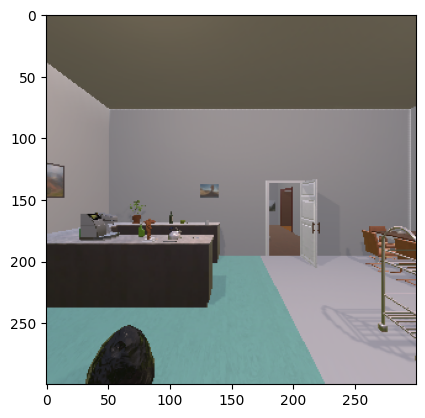

In [42]:
rnd_try = RNDIntrinsicReward()
event = controller.step(
    action="TeleportFull",
    x=spawn["x"],
    y=spawn["y"],
    z=spawn["z"],
    rotation={"x": 0, "y": 90, "z": 0},
    horizon=0,
    standing=True
)
plt.imshow(event.frame)

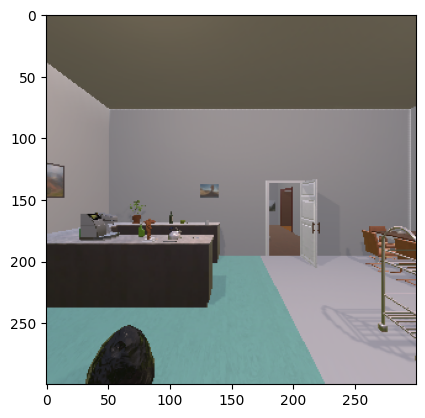

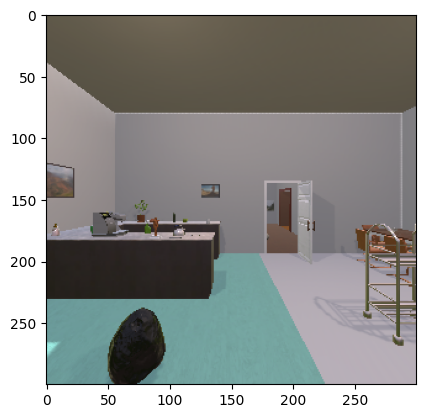

[0.37168812556663855, 0.35295821749026773, 0.33601757235581, 0.32074046640548237, 0.3075380666881388] 0.3359046995138182


In [43]:
event = controller.step("Pass")

rws = []
for i in range(5):
    rw1 = rnd_try.compute_reward(rnd_try.pre_process_rnd(event))
    rws.append(rw1)
plt.imshow(event.frame)
plt.show()
event = controller.step("MoveBack")
plt.imshow(event.frame)
plt.show()
rw3 = rnd_try.compute_reward(rnd_try.pre_process_rnd(event))
print(rws, rw3)
# plt.imshow(event.frame.copy())

# Start Training

In [44]:
class RolloutBuffer:
    def __init__(self):
        self.obs, self.actions, self.logps = [], [], []
        self.rewards, self.values, self.dones = [], [], []
    def add(self, obs, action_idx, logp, reward, value, done):
        self.obs.append(obs.cpu())              # store CPU to save VRAM
        self.actions.append(int(action_idx))
        self.logps.append(float(logp))
        self.rewards.append(float(reward))
        self.values.append(float(value))
        self.dones.append(bool(done))
    def __len__(self): 
        return len(self.rewards)


In [45]:
event = controller.step("Pass")


actor_critic_encoder = CNNEncoder(FEAT_DIM, 1).to(DEVICE)
actor   = Actor(FEAT_DIM, NUM_ACTIONS).to(DEVICE)
critic  = Critic(FEAT_DIM).to(DEVICE)

optimizer = torch.optim.Adam(
    list(actor_critic_encoder.parameters()) + list(actor.parameters()) + list(critic.parameters()),
    lr=LR
)
rnd_reward = RNDIntrinsicReward()


In [46]:
from abc import ABC, abstractmethod

def obs_from_event(event):
    frame = event.frame.copy()
    return transform(frame).to(DEVICE)  # (3,H,W) tensor


class Env(ABC):
    @abstractmethod
    def step_env(self, controller, action_idx):
        pass


class RNDIntrinsicEnv(Env):
    def __init__(self, reward_module: RNDIntrinsicReward):
        self.reward_module = reward_module

    def step_env(self, controller, action_idx):
        action_str = ACTIONS[action_idx]
        event = controller.step(action_str)

        feats = self.reward_module.pre_process_rnd(event)
        reward = self.reward_module.compute_reward(feats)
        if "Move" in action_str:
            reward = reward * 1.5 if reward > 0 else reward / 1.5
        return event, reward


In [ ]:
@torch.no_grad()
def act_and_value(obs_seq):  # obs_seq: (1, seq_len, 3, H, W)
    # Encode each frame individually
    b, s, c, h, w = obs_seq.shape
    
    feats = actor_critic_encoder(obs_seq)             # (B, seq_len, FEAT_DIM)

    # Actor: uses sequence
    logits = actor(feats.view(b, s, actor_critic_encoder.feat_dim))   # (B, NUM_ACTIONS)
    feat_last = feats[:, -1, :]                       # (B, FEAT_DIM)
    value = critic(feat_last)      


    # Critic: only use last frame (current state)
                   # (B, 1)
    return logits, value.item()

def evaluate_batch(obs, actions):
    """
    obs:     (B, S, 3, H, W)
    actions: (B*S,)
    returns:
        logps:      (B*S,)
        entropies:  (B*S,)
        values:     (B*S,)
    """
    b, s, c, h, w = obs.shape

    feats = actor_critic_encoder(obs)  # (B, S, D)

    # 3) Transformer over full sequence with causal mask
    result = []

    causal_mask = torch.full((s, s), float('-inf'), device=feats.device)
    causal_mask = torch.triu(causal_mask, diagonal=1)
    z = actor.transformer(feats, mask=causal_mask).view(b*s, -1)  # (B, S, D)


    logits = actor.policy_head(z)
    dist = torch.distributions.Categorical(logits=logits)

    logps     = dist.log_prob(actions)                      # (B*S,)
    entropies = dist.entropy()                              # (B*S,)
    # 6) Value per prefix: use last-state representation at each prefix (z at time t)
    values = critic(z).squeeze(-1)            # (B*S,)

    return logps, entropies, values

In [48]:
def compute_gae(rewards, values, dones, gamma=GAMMA, lam=GAE_LAMBDA):
    T = len(rewards)
    adv = torch.zeros(T, dtype=torch.float32)
    vals = torch.tensor(values + [0.0], dtype=torch.float32)  # bootstrap V_{T}=0 unless you pass last V
    lastgaelam = 0.0
    for t in reversed(range(T)):
        nonterminal = 1.0 - float(dones[t])
        delta = rewards[t] + gamma * vals[t+1] * nonterminal - vals[t]
        lastgaelam = delta + gamma * lam * nonterminal * lastgaelam
        adv[t] = lastgaelam
    ret = adv + vals[:-1]
    return adv, ret

In [49]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

def ppo_update(buffer: RolloutBuffer):
    """
    PPO update compatible with:
      - Transformer actor (takes obs sequences: (B, seq_len, 3, H, W))
      - CNN critic (uses only last frame embedding)
    """
    T = len(buffer)
    c, h, w = buffer.obs[0].shape
    obs = torch.stack(buffer.obs).to(DEVICE).view(MINIBATCHES, T // MINIBATCHES, c, h, w)               # (T, seq_len, 3, H, W)
    actions = torch.tensor(buffer.actions, dtype=torch.long, device=DEVICE)  # (T,)
    old_logps = torch.tensor(buffer.logps, dtype=torch.float32, device=DEVICE)
    # Compute advantages and returns
    advantages, returns = compute_gae(buffer.rewards, buffer.values, buffer.dones)
    advantages = torch.tensor(advantages, dtype=torch.float32, device=DEVICE)
    returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
    # Normalize advantages globally
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    for epoch in range(TRAIN_EPOCHS):
        # Forward through actor + critic
        new_logp, entropy, value_pred = evaluate_batch(obs, actions)
        # PPO ratio
        ratio = torch.exp(new_logp - old_logps)
        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1.0 - PPO_CLIP, 1.0 + PPO_CLIP) * advantages
        policy_loss = -torch.min(surr1, surr2).mean()
        # Value and entropy losses
        value_loss = F.mse_loss(value_pred.reshape(*returns.shape), returns)
        entropy_bonus = entropy.mean()
        # Final total loss
        loss = policy_loss + VALUE_COEF * value_loss - ENTROPY_COEF * entropy_bonus
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(
            list(actor_critic_encoder.parameters()) +
            list(actor.parameters()) +
            list(critic.parameters()),
            MAX_GRAD_NORM
        )
        optimizer.step()

        # Optional: print every few epochs
        if epoch % 10 == 0:
            print(f"[PPO] Epoch {epoch}: Loss={loss.item():.4f}, Policy={policy_loss.item():.4f}, Value={value_loss.item():.4f}")



In [50]:
def teleport(controller):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [51]:
def train(controller, env: Env, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            for t in range(1, EPISODE_STEPS + 1):
                obs_t = obs_from_event(event)  # (C,H,W)
                obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0)
                logits, value = act_and_value(obs_seq)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                # E greedy step
                if np.random.rand() < EPSILON:
                    action_idx = torch.randint(0, NUM_ACTIONS, (1,), device=DEVICE)
                    logp = dist.log_prob(action_idx)

                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t)
                rewards.append(reward)

                # 50% chance of teleport
                if done and np.random.rand() > 0.5:
                    event = teleport(controller)
                    # rnd_reward.reset()
                
        ppo_update(buf)
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
    plt.plot(rewards)
    plt.show()
    return buf

/tmp/ipykernel_534994/3353356045.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  advantages = torch.tensor(advantages, dtype=torch.float32, device=DEVICE)
/tmp/ipykernel_534994/3353356045.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)


[PPO] Epoch 0: Loss=12.7077, Policy=0.0012, Value=25.5464
[PPO] Epoch 10: Loss=7.8366, Policy=-0.0032, Value=15.8133
[PPO] Epoch 20: Loss=4.3691, Policy=-0.0042, Value=8.8802
[PPO] Epoch 30: Loss=2.1591, Policy=-0.0065, Value=4.4615
[PPO] Epoch 40: Loss=1.4566, Policy=-0.0157, Value=3.0782
[PPO] Epoch 50: Loss=0.9588, Policy=-0.0160, Value=2.0838
[PPO] Epoch 60: Loss=0.5627, Policy=-0.0173, Value=1.2933
[PPO] Epoch 70: Loss=0.4277, Policy=-0.0173, Value=1.0237
[PPO] Epoch 80: Loss=0.3156, Policy=-0.0189, Value=0.8031
[PPO] Epoch 90: Loss=0.1385, Policy=-0.0206, Value=0.4514
[PPO] Epoch 100: Loss=0.1588, Policy=-0.0202, Value=0.4908
[PPO] Epoch 110: Loss=0.1969, Policy=-0.0209, Value=0.5692
[PPO] Epoch 120: Loss=0.1876, Policy=-0.0225, Value=0.5532
[PPO] Epoch 130: Loss=0.1169, Policy=-0.0228, Value=0.4132
[PPO] Epoch 140: Loss=0.1185, Policy=-0.0207, Value=0.4118
Update 1/10 — steps: 1024
[PPO] Epoch 0: Loss=36.6512, Policy=0.0046, Value=73.4266
[PPO] Epoch 10: Loss=16.8094, Policy=-0.

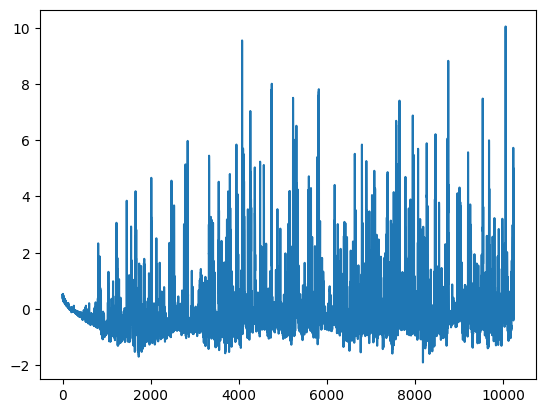

In [14]:
rnd_intrinsic_env = RNDIntrinsicEnv(rnd_reward)
buf = train(controller, rnd_intrinsic_env)

# Testing Code

In [73]:
EPISODE_STEPS = 5

buffer = RolloutBuffer()

env = RNDIntrinsicEnv(rnd_reward)
total_updates=10

for mb in range(MINIBATCHES):
    # collect episodes
    episode_seq = []
    for t in range(1, EPISODE_STEPS + 1):
        obs_t = obs_from_event(event)  # (C,H,W)
        obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0)
        logits, value = act_and_value(obs_seq)
        dist = torch.distributions.Categorical(logits=logits)
        action_idx = dist.sample()
        logp = dist.log_prob(action_idx)
        # E greedy step
        if np.random.rand() < EPSILON:
            action_idx = torch.randint(0, NUM_ACTIONS, (1,), device=DEVICE)
            logp = dist.log_prob(action_idx)

        action_idx, logp = action_idx.item(), logp.item()
        event, reward = env.step_env(controller, action_idx)
        done = t == EPISODE_STEPS

        # store one step
        buffer.add(obs_t, action_idx, logp, reward, value, done)
        episode_seq.append(obs_t)

        # 50% chance of teleport
        if done and np.random.rand() > 0.5:
            event = teleport(controller)
            # rnd_reward.reset()

In [74]:
buffer.rewards, buffer.dones, buffer.actions, buffer.logps, buffer.obs

([0.20886823024062828,
  0.2926736568465564,
  0.18246496659205083,
  0.18498285848916884,
  0.26698116716407333,
  0.2842147285708417,
  0.16599953824525768,
  0.20796729520000223,
  0.19318242718235346,
  0.21097853496901678,
  0.1614341283313632,
  0.23761520150990617,
  0.2376709007096264,
  0.16288009348819643,
  0.23843959974116266,
  0.23016180690617763,
  0.14379182961941073,
  0.20838900634875593,
  0.19506925919438645,
  0.1943057805617326],
 [False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  True],
 [2, 0, 2, 3, 0, 1, 2, 2, 2, 2, 3, 0, 0, 3, 0, 0, 2, 0, 1, 1],
 [-1.0390539169311523,
  -1.2504708766937256,
  -1.1091183423995972,
  -1.7884806394577026,
  -1.0947344303131104,
  -1.8915038108825684,
  -1.0565414428710938,
  -1.1100207567214966,
  -1.0806231498718262,
  -1.149745225906372,
  -1.5677134990692139,
  -1.0911188125610352,
  -1.1268457174301147,
  -1.7

### PPO Update stage

In [75]:
# Fn Start
T = len(buffer)
c, h, w = buffer.obs[0].shape
obs = torch.stack(buffer.obs).to(DEVICE).view(MINIBATCHES, T // MINIBATCHES, c, h, w)               # (T, seq_len, 3, H, W)
actions = torch.tensor(buffer.actions, dtype=torch.long, device=DEVICE)  # (T,)
old_logps = torch.tensor(buffer.logps, dtype=torch.float32, device=DEVICE)
# Compute advantages and returns
advantages, returns = compute_gae(buffer.rewards, buffer.values, buffer.dones)
advantages = advantages.to(dtype=torch.float32, device=DEVICE)
returns = returns.to(dtype=torch.float32, device=DEVICE)
# Normalize advantages globally
advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

In [76]:
rewards = buffer.rewards
values = buffer.values
dones = buffer.dones
gamma = GAMMA
lam = GAE_LAMBDA

# Fn start
T = len(rewards)
adv = torch.zeros(T, dtype=torch.float32)
vals = torch.tensor(values + [0.0], dtype=torch.float32)  # bootstrap V_{T}=0 unless you pass last V
lastgaelam = 0.0
for t in reversed(range(T)):
    nonterminal = 1.0 - float(dones[t])
    delta = rewards[t] + gamma * vals[t+1] * nonterminal - vals[t]
    lastgaelam = delta + gamma * lam * nonterminal * lastgaelam
    adv[t] = lastgaelam
ret = adv + vals[:-1]

In [ ]:
b, s, c, h, w = obs.shape

feats = actor_critic_encoder(obs)  # (B, S, D)

# 3) Transformer over full sequence with causal mask
result = []

causal_mask = torch.full((s, s), float('-inf'), device=feats.device)
causal_mask = torch.triu(causal_mask, diagonal=1)
z = actor.transformer(feats, mask=causal_mask).view(b*s, -1)  # (B, S, D)


logits = actor.policy_head(z)
dist = torch.distributions.Categorical(logits=logits)

logps     = dist.log_prob(actions)                      # (B*S,)
entropies = dist.entropy()                              # (B*S,)
# 6) Value per prefix: use last-state representation at each prefix (z at time t)
values = critic(z).squeeze(-1)            # (B*S,)

logps, values

(tensor([-1.3078, -1.1191, -1.2791, -1.6472, -1.2689, -1.7687, -1.0924, -0.9710,
         -1.0763, -1.0687, -1.7747, -1.0116, -1.3689, -1.5133, -1.0529, -1.3586,
         -1.0308, -1.4019, -1.5972, -1.5460], grad_fn=<SqueezeBackward1>),
 tensor([0.1332, 0.1216, 0.1039, 0.1368, 0.0947, 0.0418, 0.1118, 0.1048, 0.1086,
         0.0937, 0.0707, 0.0923, 0.0999, 0.0610, 0.1161, 0.1153, 0.1023, 0.0448,
         0.0973, 0.0775], grad_fn=<SqueezeBackward1>))

# Final Inference

tensor([[0.4961, 0.1992, 0.2229, 0.0818]], device='cuda:0')
tensor([[0.4865, 0.1648, 0.2709, 0.0778]], device='cuda:0')
tensor([[0.5055, 0.2186, 0.2128, 0.0631]], device='cuda:0')
tensor([[0.5453, 0.1586, 0.2140, 0.0821]], device='cuda:0')
tensor([[0.5912, 0.1605, 0.1822, 0.0662]], device='cuda:0')
tensor([[0.5487, 0.1807, 0.2015, 0.0691]], device='cuda:0')
tensor([[0.5513, 0.1954, 0.1709, 0.0824]], device='cuda:0')
tensor([[0.5568, 0.1869, 0.1746, 0.0817]], device='cuda:0')
tensor([[0.5394, 0.1733, 0.2095, 0.0778]], device='cuda:0')
tensor([[0.5559, 0.1722, 0.2128, 0.0591]], device='cuda:0')
tensor([[0.5668, 0.1398, 0.2122, 0.0811]], device='cuda:0')
tensor([[0.5195, 0.1862, 0.2131, 0.0812]], device='cuda:0')
tensor([[0.5135, 0.1962, 0.2060, 0.0843]], device='cuda:0')
tensor([[0.5552, 0.1906, 0.1756, 0.0786]], device='cuda:0')
tensor([[0.6024, 0.1583, 0.1440, 0.0953]], device='cuda:0')
tensor([[0.5661, 0.1543, 0.2178, 0.0619]], device='cuda:0')
tensor([[0.5661, 0.1450, 0.2154, 0.0735]

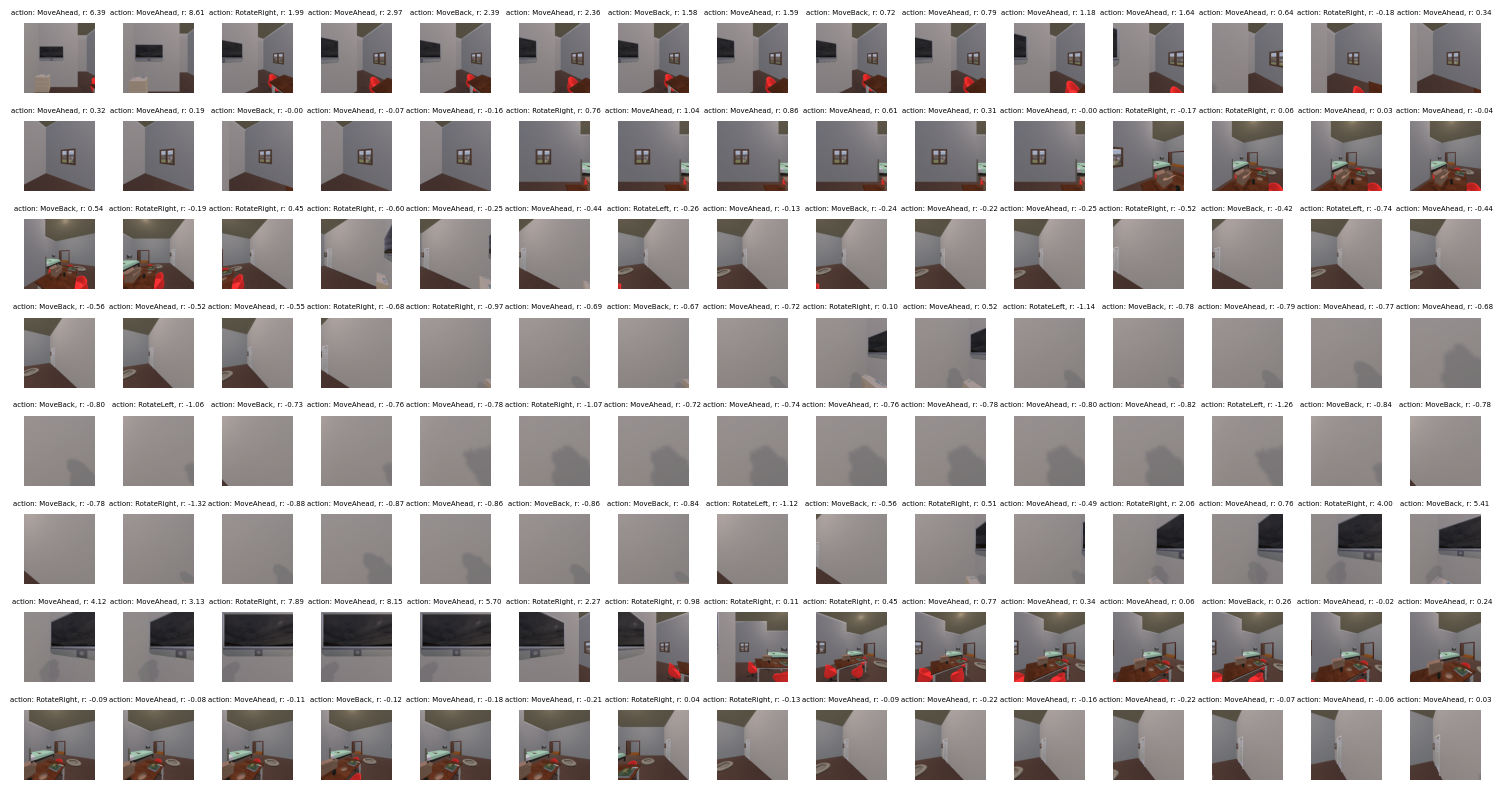

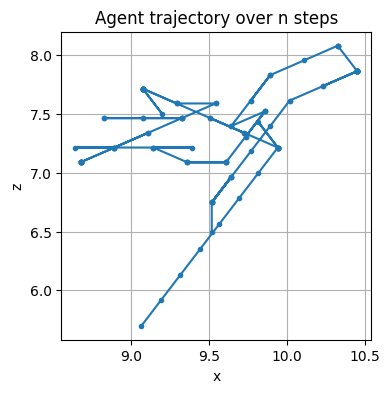

In [25]:
import matplotlib.pyplot as plt
import numpy as np

n = 120
n_row = 8
positions = []

plt.figure(figsize=(n // n_row, n_row))
event = teleport(controller)

episode_seq = []
for t in range(1, n + 1):
    obs_t = obs_from_event(event)  # (C,H,W)
    obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0)
    logits, value = act_and_value(obs_seq)
    dist = torch.distributions.Categorical(logits=logits)
    print(torch.softmax(logits, dim=1))
    action_idx = dist.sample()
    # action_idx = np.random.randint(0, 4)

    event, reward = rnd_intrinsic_env.step_env(controller, action_idx)
    done = t == EPISODE_STEPS

    # Extract agent position from metadata
    pos = event.metadata["agent"]["position"]
    positions.append((pos["x"], pos["z"]))  # store x,z

    # Plot frame and action
    plt.subplot(n_row, n // n_row, t)
    plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}", fontsize=5)
    plt.axis(False)
    plt.imshow(event.frame)

plt.tight_layout()
plt.show()

# ---- Plot 2D trajectory of the agent ----
positions = np.array(positions)
plt.figure(figsize=(4, 4))
plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Agent trajectory over n steps")
plt.grid(True)
plt.show()


In [26]:
controller.stop()

# CLIP Novelty

In [27]:
class CLIPNovelty:
    """
    Computes intrinsic reward = 1 - mean cosine similarity
    between current CLIP embedding and last N embeddings.
    """
    def __init__(self, device=DEVICE, model_name="ViT-B/32", buffer_size=EPISODE_STEPS):
        self.device = device
        self.model, self.preprocess = clip.load(model_name, device=device)
        self.buffer = deque(maxlen=buffer_size)
        self.buffer_size = buffer_size

    @torch.no_grad()
    def compute_reward(self, frame_np):
        """
        frame_np : np.ndarray (H,W,3) uint8
        returns : float intrinsic reward
        """
        img = Image.fromarray(frame_np)
        img_t = self.preprocess(img).unsqueeze(0).to(self.device)
        emb = self.model.encode_image(img_t)
        emb = emb / emb.norm(dim=-1, keepdim=True)  # normalize to unit sphere

        if len(self.buffer) == 0:
            self.buffer.append(emb)
            return 0.0  # no past frames to compare yet

        past = torch.cat(list(self.buffer), dim=0)  # (N, D)
        sim = F.cosine_similarity(emb, past)        # (N,)
        reward = (1 - sim.mean()).item()
        self.buffer.append(emb)
        return reward
    
    def reset(self):
        self.buffer = deque(maxlen=self.buffer_size)


clip_novelty = CLIPNovelty()

In [28]:
house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [29]:
class ClipEnv(Env):
    def __init__(self, clip_novelty: CLIPNovelty):
        super().__init__()
        
    def step_env(self, controller, action_idx):
        action_str = ACTIONS[action_idx]
        event = controller.step(action_str)
    
        reward = clip_novelty.compute_reward(event.frame)
        if "Move" in action_str:
            reward = reward * 1.5 if reward > 0 else reward / 1.5
        return event, reward

/tmp/ipykernel_534994/3353356045.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  advantages = torch.tensor(advantages, dtype=torch.float32, device=DEVICE)
/tmp/ipykernel_534994/3353356045.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)


[PPO] Epoch 0: Loss=9.1668, Policy=0.0123, Value=18.4201
[PPO] Epoch 10: Loss=0.0511, Policy=-0.0038, Value=0.2160
[PPO] Epoch 20: Loss=0.0369, Policy=-0.0090, Value=0.1953
[PPO] Epoch 30: Loss=0.0246, Policy=-0.0110, Value=0.1799
[PPO] Epoch 40: Loss=0.0068, Policy=-0.0152, Value=0.1505
[PPO] Epoch 50: Loss=-0.0082, Policy=-0.0056, Value=0.1086
[PPO] Epoch 60: Loss=-0.0128, Policy=-0.0011, Value=0.0829
[PPO] Epoch 70: Loss=-0.0395, Policy=-0.0184, Value=0.0625
[PPO] Epoch 80: Loss=-0.0489, Policy=-0.0220, Value=0.0500
[PPO] Epoch 90: Loss=-0.0545, Policy=-0.0212, Value=0.0391
[PPO] Epoch 100: Loss=-0.0634, Policy=-0.0246, Value=0.0283
[PPO] Epoch 110: Loss=-0.0674, Policy=-0.0280, Value=0.0261
[PPO] Epoch 120: Loss=-0.0714, Policy=-0.0305, Value=0.0236
[PPO] Epoch 130: Loss=-0.0749, Policy=-0.0315, Value=0.0223
[PPO] Epoch 140: Loss=-0.0817, Policy=-0.0349, Value=0.0156
Update 1/10 — steps: 1024
[PPO] Epoch 0: Loss=1.6861, Policy=0.0447, Value=3.4075
[PPO] Epoch 10: Loss=0.2285, Polic

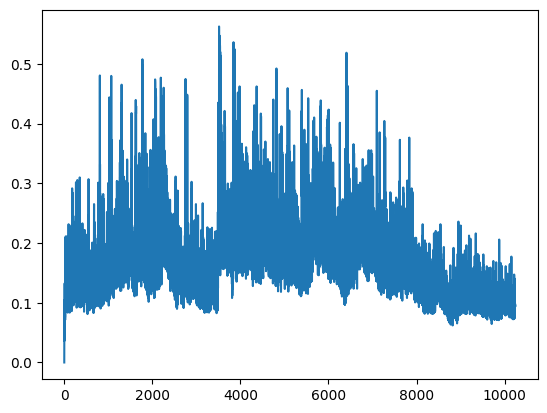

In [30]:
clip_env = ClipEnv(clip_novelty)
buf = train(controller, clip_env)

tensor([[0.0113, 0.0007, 0.3718, 0.6161]], device='cuda:0')
tensor([[0.0103, 0.0011, 0.3866, 0.6021]], device='cuda:0')
tensor([[0.0097, 0.0014, 0.3758, 0.6131]], device='cuda:0')
tensor([[0.0200, 0.0010, 0.2949, 0.6841]], device='cuda:0')
tensor([[0.0116, 0.0008, 0.3589, 0.6286]], device='cuda:0')
tensor([[0.0123, 0.0011, 0.3800, 0.6066]], device='cuda:0')
tensor([[0.0100, 0.0015, 0.6601, 0.3285]], device='cuda:0')
tensor([[0.0112, 0.0010, 0.4486, 0.5392]], device='cuda:0')
tensor([[0.0087, 0.0008, 0.3453, 0.6451]], device='cuda:0')
tensor([[0.0170, 0.0009, 0.2578, 0.7243]], device='cuda:0')
tensor([[0.0106, 0.0009, 0.3385, 0.6500]], device='cuda:0')
tensor([[0.0123, 0.0008, 0.4970, 0.4899]], device='cuda:0')
tensor([[0.0143, 0.0015, 0.5640, 0.4202]], device='cuda:0')
tensor([[0.0264, 0.0013, 0.3522, 0.6201]], device='cuda:0')
tensor([[0.0278, 0.0024, 0.3449, 0.6249]], device='cuda:0')
tensor([[0.0157, 0.0007, 0.3774, 0.6061]], device='cuda:0')
tensor([[0.0087, 0.0009, 0.4288, 0.5616]

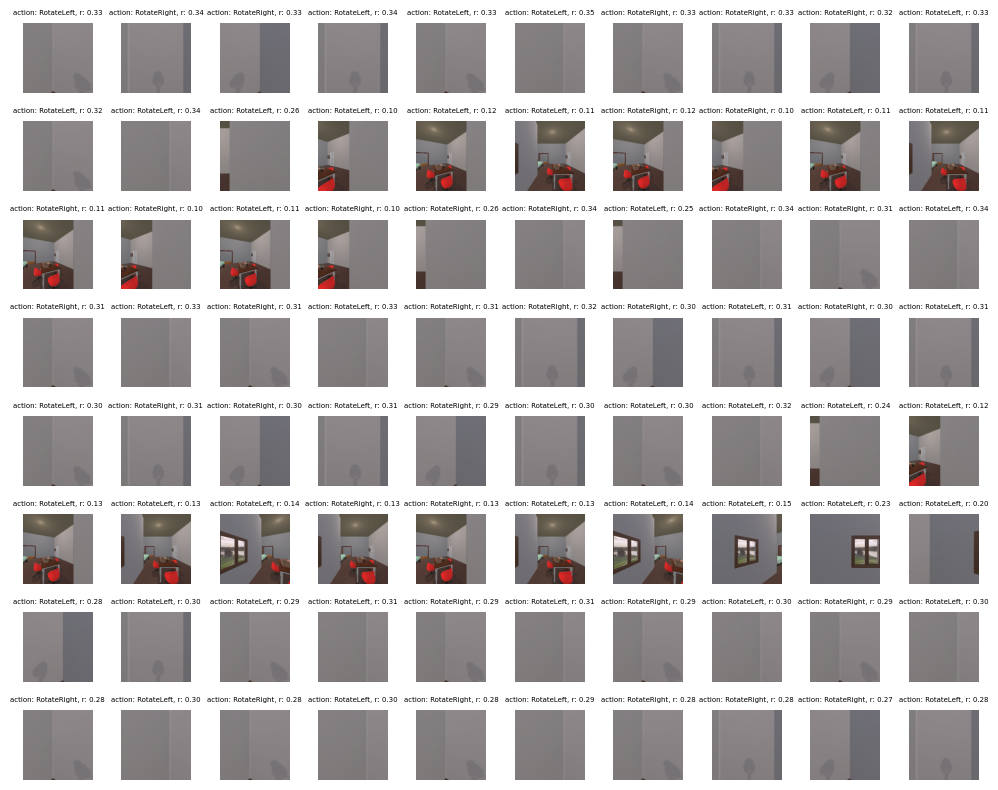

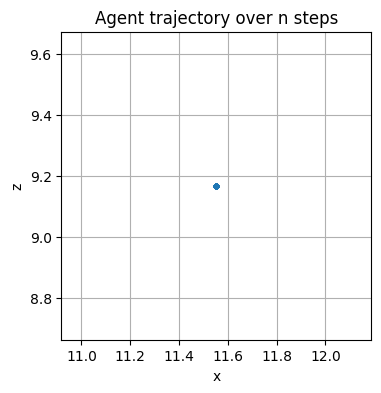

In [31]:
import matplotlib.pyplot as plt
import numpy as np

n = 80
n_row = 8
positions = []

plt.figure(figsize=(n // n_row, n_row))
event = teleport(controller)

episode_seq = []
for t in range(1, n + 1):
    obs_t = obs_from_event(event)  # (C,H,W)
    obs_seq = torch.stack(episode_seq + [obs_t], dim=0).unsqueeze(0)
    logits, value = act_and_value(obs_seq)
    dist = torch.distributions.Categorical(logits=logits)
    print(torch.softmax(logits, dim=1))
    action_idx = dist.sample()
    # action_idx = np.random.randint(0,4)

    event, reward = clip_env.step_env(controller, action_idx)
    done = t == EPISODE_STEPS

    # Extract agent position from metadata
    pos = event.metadata["agent"]["position"]
    positions.append((pos["x"], pos["z"]))  # store x,z

    # Plot frame and action
    plt.subplot(n_row, n // n_row, t)
    plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}", fontsize=5)
    plt.axis(False)
    plt.imshow(event.frame)

plt.tight_layout()
plt.show()

# ---- Plot 2D trajectory of the agent ----
positions = np.array(positions)
plt.figure(figsize=(4, 4))
plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
plt.xlabel("x")
plt.ylabel("z")
plt.title("Agent trajectory over n steps")
plt.grid(True)
plt.show()


In [22]:
controller.stop()